# xesmf issues with Small size problems and Structured grids with masks

**Quick Description**

This notebook is intended to describe issues encountered with package xesmf in the case of structured grid problems with 'bilinear' interpolation method. Tests were conducted on HPC facilities. The xesmf package was installed with conda. The conda binaries (from the conda-forge channel) versions are :

- esmf-8.0.1, esmpy-8.0.1
- xesmf-0.6.2

**More information**


The issue arose when performing the computation of the interpolation weights in order to map some source grid data onto a a destination grid defined as 2D-arrays of longitude, latitude and using a **mask**

a 'bilinear' intepolation method with extrapolation option (```method='bilinear'``` 'nearest_s2d' )

using real data where source and destination grids were provided as xarray.Dataset and defined as 2D-arrays of longitude, latitude and using a **mask**

The issue arise when the regridding involves a source and a destination grid both defined with a **mask** as 2D-arrays of longitude, latitude. It arose with *real data* but it is reproduced in this notebook with synthetic grids [prepared with xesmf.util.grid_2d](https://github.com/pangeo-data/xESMF/blob/master/doc/notebooks/Backend.ipynb?). The tested regridding options involve a 'bilinear' intepolation method with extrapolation option and request to save the weights to a netCDF file : (i) ```method='bilinear'``` and ```extrap_method='nearest_s2d'```, (ii) ```weights=None``` and ```reuse_weights=False```, and (iii) ```filename``` set to a string defining a valid path and netCDF name. These options should enable to perform the computation of the interpolation weights (reuse_weights=False and weights=None) and should write the interpolation weights to a netCDF file.

This notebook **describes the issues** and **enables to reproduce the errors**. It **provide fixes**.

However, the fixes might not be fully statisfying since the **real bottleneck under the hood** is connected to the ```xesmf``` extensive use of ```xarray.DataArray``` or ```xarray.Dataset``` to wrap up the 2D-rectangular matrix of interpolation weights. The **interpolation weight matrix** is **sparse**. It is therefore relevant to represent it as a  **```scipy.sparse``` or ```sparse.COO``` 2D-array** in order to **save memory space**. However, **```xarray``` package does not currently handles sparse array object**. Each time xesmf wraps up the ```sparse.COO``` weight array into an ```xarray.DataArray``` or ```xarray.Dataset```, the sparse object is converted back to a regular ```numpy.ndarray``` **using memory for the full size weight matrix**.

Unless ```xarray``` upgrades to handle the sparse object correctly this raises conflicting requirements for the ```xesmf``` packages : (i) being efficient in terms of Memory use, and (ii) on the other hand being a powerful and user-friendly tool handling high-level python package  such as ```xarray``` (and ```dask```).

This makes the transition to the second type of issues : **large regridding problem**. This jupyter-notebook is twined with XXX because the issue is a two-fold problems. In the second notebook, we also propose solutions or ***fixes*** in order to coopt with the conflicting requirements.

**[Issue 1 and fix](#Issue1)**  

1. Loading the [original conda-forge xesmf package](#Loading-the-original-conda-forge-xesmf-package)
2. [Preparing the synthetic source and destination grid data](#Reproducing-the-error-with-ad-hoc-synthetic-data) with ```xesmf.util.grid_2d```, *importantly to reproduce the error* [add masks to the synthetic grids](#Creating-the-source-grid-mask).
3. Launching the [computation of the interpolation weights](#Triggering-the-computation-of-the-interpolation-weights).
4. [Error arising in the regridder](#Regridder-weights-Failure-with-the-original-xesmf-package) : ```AttributeErrorr```.  
5. [Regridder Error arising in the smm.py function ```add_nans_to_weights```](#Regridder-Failure-arise-in-the-function-which-replaces-zeros-by-NaNs-for-unmapped-grid-points) line 221, at the end of the instanciation of the BaseRegridder class object which causes the python script to fail.
5.[Proposed fix the Issue 1](#Proposed-fix-to-issue-1).

**[Issue 2 and fixes](#Issue2)**  

1. [Applying the fix to issue1](#Applying-the-fix-to-issue1) by loading a modified xesmf package.
2. Using again the source and destination grid+data as applied for Issue 1 experiment.
3. Performing again the [computation of the interpolation weights](#Launching-again-the-regridding-with-the-modified-xesmf-package-having-fix-to-issue1)
3. [Error arising in the regridder](#Regridder-weights-Failure-with-the-modified-xesmf-package-having-fix-to-issue1): ```AttributeErrorr```
4. [Regridder Error arising when saving the weights to a netCDF file](#Regridder-Failure-when-saving-the-weights-to-a-netCDF-file) with the ```Class BaseRegridder``` method ```to_necdf(self,filename=None)```, within the ```frontend.py``` source at line 644.
5. [Proposed fix the Issue 2](#Proposed-fix-the-Issue2).
6. [Applying the fix to issue2](#Applying-the-fix-to-issue2) by loading [a modified xesmf package](#Loading-the- modified-xesmf-package-with-fix-to-issue1-and-2).
7. Performing again the [computation of the interpolation weights with fixes to the Issue1 and Issue2](#Triggering-again-the-computation-of-the-weights-with-fixes-to-issue1-and-2)
8. [Regridder success](#Regridder-success-with-fixes-to-issue1-and-2)

**[Maps of Regridded data with fixes to issue1 and 2](#Maps-of-Regridded-data-with-fixes-to-issue1-and-2)** 

**[CONCLUSION AND NEW TESTS AND FIXES WITH LARGE SCALE PROBLEM](#CONCLUSION-AND-NEW-TESTS-AND-FIXES-WITH-LARGE-SCALE-PROBLEM)**


I really like the idea of having a wrapper to esmpy/ESMF which enables the use of xarray objects eventhough I ran into several issues/bugs for which I developed my own solutions. 

These issues are connected to the many possible types of object handled by xesmf backend.py and smm.py. More precisely xarray.DataArray or xarray.Dataset backed by :
- either numpy.ndarray or dask.Array for the source and destination grid and data,
- scipy.sparse (coo.array or lil_array) or sparse.COO objects for the 2D-rectangular matrix of weights which enable to map the source grid data to the destination grid.

# Issue1

# Loading the original conda-forge xesmf package
<!-- Loading-the-original-conda-forge-xesmf-package -->

In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import xesmf as xe

In [2]:
print('xesmf  version {0}'.format(xe.__version__))
print('xarray version {0}'.format(xr.__version__))
print('numpy  version {0}'.format(np.__version__))

xesmf  version 0.6.2
xarray version 2022.3.0
numpy  version 1.20.2


In [3]:
import scipy
import sparse as sps
print('scipy  version {0}'.format(scipy.__version__))
print('sparse version {0}'.format(sps.__version__))

scipy  version 1.6.2
sparse version 0.3.1


# Reproducing the error with ad hoc synthetic data
<!--Reproducing-the-error-with-ad-hoc-synthetic-data-->

The demonstration is conducted with data prepared with xesmf.util.grid_2d [as explained in the doc](https://github.com/pangeo-data/xESMF/blob/master/doc/notebooks/Backend.ipynb?)

The issue was initially raised using real data where source and destination grids were provided as xarray.Dataset and defined as 2D-arrays of longitude, latitude and using a **mask** (the grid and data arrays were eventually modified to be C-contiguous).

Here with reproduce this issue on a smaller problem defined on a limited area with :

 - the xarray.Dataset ```ds_in``` contains source grid and data,
 - the xarray.Dataset ```ds_out``` is the destination grid.
 
We need to prepare an ad hoc mask for the input and output grids.

In [4]:
lonmin, lonmax =  -6., 10. 
latmin, latmax =  34.5, 45.

In [5]:
ds_in  = xe.util.grid_2d(lonmin, lonmax, 0.4, latmin, latmax, 0.3) 
ds_out = xe.util.grid_2d(lonmin, lonmax, 0.6, latmin, latmax, 0.4)

## Creating the source grid mask
<!--Creating-the-source-grid-mask-->

In [6]:
#= ds_in.assign_coords({'lon': (ds_in['lon'],{'long_name' : 'Longitude', 'units' : 'degree_north'})} )
ds_in

<xarray.Dataset>
Dimensions:  (y: 35, x: 40, y_b: 36, x_b: 41)
Coordinates:
    lon      (y, x) float64 -5.8 -5.4 -5.0 -4.6 -4.2 ... 8.2 8.6 9.0 9.4 9.8
    lat      (y, x) float64 34.65 34.65 34.65 34.65 ... 44.85 44.85 44.85 44.85
    lon_b    (y_b, x_b) float64 -6.0 -5.6 -5.2 -4.8 -4.4 ... 8.8 9.2 9.6 10.0
    lat_b    (y_b, x_b) float64 34.5 34.5 34.5 34.5 34.5 ... 45.0 45.0 45.0 45.0
Dimensions without coordinates: y, x, y_b, x_b
Data variables:
    *empty*

In [7]:
ds_in['mask']=xr.ones_like(ds_in['lon'])
ds_in['mask'].data.shape

(35, 40)

In [8]:
ds_in['mask'].name='mask'
ds_in['mask'].data[0:4,:]=0
ds_in['mask'].data[:,0:20]=0

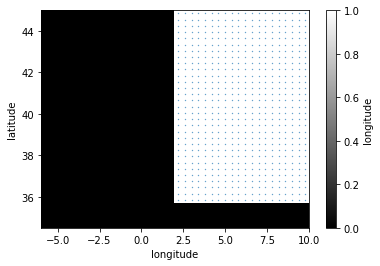

In [9]:
ds_in['mask'].plot(x='lon',y='lat',cmap='binary_r')
ax=plt.gca()
ax.scatter( ds_in['lon'].where(ds_in['mask']), ds_in['lat'].where(ds_in['mask']), s=0.1)

## Source grid and data organized as C-contiguous

In [10]:
ds_in["lon"].data.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

In [11]:
ds_in["lon"].values=ds_in["lon"].values.copy(order='F')
ds_in["lat"].values=ds_in["lat"].values.copy(order='F')

In [12]:
ds_in["lon"].data.flags

  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

**Data 2D and 4D : check C-contiguity**

In [13]:
#ntimes,nlevs=11,51
ntimes,nlevs=2,3
ds_in.coords["time"] = np.arange(1, ntimes)
ds_in.coords["lev"] = np.arange(1, nlevs)
ds_in["data2D"] = xe.data.wave_smooth(ds_in["lon"], ds_in["lat"])
ds_in["data4D"] = ds_in["time"] * ds_in["lev"] * ds_in["data2D"]

In [14]:
ds_in["data2D"].values.flags

  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

## Creating the destination grid mask

In [15]:
#= ds_in.assign_coords({'lon': (ds_in['lon'],{'long_name' : 'Longitude', 'units' : 'degree_north'})} )
ds_out

<xarray.Dataset>
Dimensions:  (y: 27, x: 27, y_b: 28, x_b: 28)
Coordinates:
    lon      (y, x) float64 -5.7 -5.1 -4.5 -3.9 -3.3 ... 7.5 8.1 8.7 9.3 9.9
    lat      (y, x) float64 34.7 34.7 34.7 34.7 34.7 ... 45.1 45.1 45.1 45.1
    lon_b    (y_b, x_b) float64 -6.0 -5.4 -4.8 -4.2 -3.6 ... 8.4 9.0 9.6 10.2
    lat_b    (y_b, x_b) float64 34.5 34.5 34.5 34.5 34.5 ... 45.3 45.3 45.3 45.3
Dimensions without coordinates: y, x, y_b, x_b
Data variables:
    *empty*

In [16]:
ds_out['mask']=xr.ones_like(ds_out['lon'])
ds_out['mask'].data.shape

(27, 27)

In [17]:
print(ds_out['mask'].name)
ds_in['mask'].name='mask'
ds_out['mask'].data[0:3,:]=0
ds_out['mask'].data[:,0:13]=0

mask


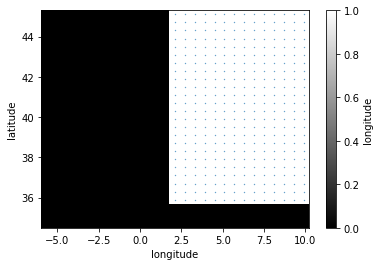

In [18]:
ds_out['mask'].plot(x='lon',y='lat',cmap='binary_r')
ax=plt.gca()
ax.scatter( ds_out['lon'].where(ds_out['mask']), ds_out['lat'].where(ds_out['mask']), s=0.1)

## Destination grid organized as C-contiguous

In [19]:
ds_out["lon"].data.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

In [20]:
ds_out["lon"].values=ds_out["lon"].values.copy(order='F')
ds_out["lat"].values=ds_out["lat"].values.copy(order='F')

In [21]:
ds_out["lon"].data.flags

  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

# Triggering the computation of the interpolation weights
<!-- Triggering-the-computation-of-the-interpolation-weights -->

We trigger the computation of the weights using the frontend.py ```BaseRegridder class``` to construct the ```reggrider``` object (i.d., method ```__init__```) with arguments ```reuse_weights=False``` and ```weights=None```. We also provide a valid ```filename``` in order to save the interpolation weights to a netCDF file.

#### Defining a file name for saving the interpolation weights to a netCDF file

In [22]:
ny_src,nx_src = ds_in["data2D"].shape[0],ds_in["data2D"].shape[1]
ny_tgt_red,nx_tgt_red = ds_out['lon'].shape[0],ds_out['lon'].shape[1]
method='bilinear'
pattern='{0}_{1}x{2}_{3}x{4}'.format(
            method,
            ny_src,
            nx_src,
            ny_tgt_red,
            nx_tgt_red)
filout_wghts='issue1_fix1_weights_'+pattern+'.nc'
print(filout_wghts)

issue1_fix1_weights_bilinear_35x40_27x27.nc


#### Regridder weights Failure with the original xesmf package

<!--  Regridder-weights-Failure-with-the-original-xesmf-package -->

In [23]:
reggrider = xe.Regridder(ds_in,ds_out, method="bilinear",extrap_method='nearest_s2d',weights=None,filename=filout_wghts)

/users/p22007/p22007lb/.conda/envs/mydap-python-tools-3.9.5/lib/python3.9/site-packages/xesmf/backend.py:38: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')


AttributeError: 'numpy.ndarray' object has no attribute 'to_scipy_sparse'

## Regridder Failure arise in the function which replaces zeros by NaNs for unmapped grid points

<!-- Regridder-Failure-arise-in-the-function-which-replaces-zeros-by-NaNs-for-unmapped-grid-points -->

**The error is**

```AttributeError: 'numpy.ndarray' object has no attribute 'to_scipy_sparse'```

**It occurs occurs in xesmf/smm.py line 221 :**

```python
m = weights.data.to_scipy_sparse().tolil()
```

The variable ```weights.data``` holds the interpolation weights calculated by the ```esmpy/ESMF``` backend . 
It is a 2D matrix mapping the source grid onto the destination grid. This matrix is a sparse matrix and benefits to be represented as such to save Memory (only non-null elements saved in memory). The ```AttributeError``` occurs line 221 within smm.py because: (i) ```xarray``` does not handle the sparse object correctly, and (ii) ```xesmf``` package tends to wrap up numpy arrays and/or sparse or scipy sparse matrix into ```xarray.DataArray``` (or xarray.Dataset). At line 221 in smm.py, the variable ```weights``` is under the wood, a ```sparse.COO``` object (i.e., multi-dimensional sparse array) *previously wrapped up into* an ```xarray.DataArray```. Unfortunatly, when ```xarray``` wraps up such sparse object, it loads the full matrix size as a simple ```numpy.ndarray``` which consumes a lot of Memory.
     
I introduced the following ["**fix**"](#Proposed-fix-to-issue-1) which enables **to convert back the numpy.ndarray back to the ```sparse.COO``` format**, here, sps.COO (and finally this enables to convert to the ```lil_array``` format of the ```scipy.sparse``` python module (itself further used to change to NaN the masked values set to zero by ESMF) :
          
```python
m = sps.COO.from_numpy(weights.data).to_scipy_sparse().tolil()
```

However **this fix does not solve the bottleneck with ```xarray``` package not being able to handle sparse array representation**. This is **especially an issue for large size problems** (real world).

**Original xesmf pacakage : smm.py source before fix**

In [24]:
# %load -r 201-229 /users/p22007/p22007lb/.conda/envs/mydap-python-tools-3.9.5/lib/python3.9/site-packages/xesmf/smm.py
def add_nans_to_weights(weights):
    """Add NaN in empty rows of the regridding weights sparse matrix.

    By default, empty rows in the weights sparse matrix are interpreted as zeroes. This can become problematic
    when the field being interpreted has legitimate null values. This function inserts NaN values in each row to
    make sure empty weights are propagated as NaNs instead of zeros.

    Parameters
    ----------
    weights : DataArray backed by a sparse.COO array
      Sparse weights matrix.

    Returns
    -------
    DataArray backed by a sparse.COO array
      Sparse weights matrix.
    """

    # Taken from @trondkr and adapted by @raphaeldussin to use `lil`.
    # lil matrix is better than CSR when changing sparsity
    m = weights.data.to_scipy_sparse().tolil()
    # replace empty rows by one NaN value at element 0 (arbitrary)
    # so that remapped element become NaN instead of zero
    for krow in range(len(m.rows)):
        m.rows[krow] = [0] if m.rows[krow] == [] else m.rows[krow]
        m.data[krow] = [np.NaN] if m.data[krow] == [] else m.data[krow]
    # update regridder weights (in COO)
    weights = weights.copy(data=sps.COO.from_scipy_sparse(m))
    return weights

In [25]:
!!ls /users/p22007/p22007lb/.conda/envs/mydap-python-tools-3.9.5/lib/python3.9/site-packages/xesmf/smm.py

['/users/p22007/p22007lb/.conda/envs/mydap-python-tools-3.9.5/lib/python3.9/site-packages/xesmf/smm.py']

In [26]:
#%pycat 201-229 '/users/p22007/p22007lb/.conda/envs/mydap-python-tools-3.9.5/lib/python3.9/site-packages/xesmf/smm.py'

## Proposed fix to issue 1
<!-- Proposed-fix-to-issue-1 -->

```xe.xesmf_fix``` package with modified smm.py source

In [27]:
# %load -r 201-229 /users/p22007/p22007lb/.conda/envs/mydap-python-tools-3.9.5/lib/python3.9/site-packages/xesmf/xesmf_fix1/smm.py
def add_nans_to_weights(weights):
    """Add NaN in empty rows of the regridding weights sparse matrix.

    By default, empty rows in the weights sparse matrix are interpreted as zeroes. This can become problematic
    when the field being interpreted has legitimate null values. This function inserts NaN values in each row to
    make sure empty weights are propagated as NaNs instead of zeros.

    Parameters
    ----------
    weights : DataArray backed by a sparse.COO array
      Sparse weights matrix.

    Returns
    -------
    DataArray backed by a sparse.COO array
      Sparse weights matrix.
    """

    # Taken from @trondkr and adapted by @raphaeldussin to use `lil`.
    # lil matrix is better than CSR when changing sparsity
    # m = weights.data.to_scipy_sparse().tolil()
    m = sps.COO.from_numpy(weights.data).to_scipy_sparse().tolil()
    # replace empty rows by one NaN value at element 0 (arbitrary)
    # so that remapped element become NaN instead of zero
    for krow in range(len(m.rows)):
        m.rows[krow] = [0] if m.rows[krow] == [] else m.rows[krow]
        m.data[krow] = [np.NaN] if m.data[krow] == [] else m.data[krow]
    # update regridder weights (in COO)
    weights = weights.copy(data=sps.COO.from_scipy_sparse(m))

# Issue2

## Triggering again the computation of the interpolation weights with fix to issue1
<!-- Triggering-again-the-computation-of-the-interpolation-weights-with-fix-to-issue1 -->

We trigger again the computation of the weights using the frontend.py ```BaseRegridder class``` to construct the ```reggrider``` object with the exact same arguments ```reuse_weights=False```, ```weights=None```, and a valid ```filename``` in order to save the interpolation weights to a netCDF file.

## Applying the fix to issue1

### Loading the modified xesmf package with fix to issue1

In [28]:
import xesmf.xesmf_fix1 as xe

### Launching again the regridding with the modified xesmf package having fix to issue1

<!-- Launching-again-the-regridding-with-the-modified-xesmf-package-having-fix-to-issue1 -->

#### Regridder weights Failure with the modified xesmf package having fix to issue1

<!--  Regridder-weights-Failure-with-the-modified-xesmf-package-having-fix-to-issue1 -->

In [29]:
reggrider = xe.Regridder(ds_in,ds_out, method="bilinear",extrap_method='nearest_s2d',weights=None,filename=filout_wghts)

/users/p22007/p22007lb/.conda/envs/mydap-python-tools-3.9.5/lib/python3.9/site-packages/xesmf/xesmf_fix1/backend.py:38: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')


AttributeError: 'numpy.ndarray' object has no attribute 'coords'

## Regridder Failure when saving the weights to a netCDF file

<!-- Regridder-Failure-when-saving-the-weights-to-a-netCDF-file -->

in the ```Class BasicRegridder``` method ```to_netcdf```

**The error is :**

```AttributeError: 'numpy.ndarray' object has no attribute 'coords'```

**It occurs occurs in xesmf/frontend.py line 644 when applying the ```Class BasicRegridder``` method ```to_netcdf```:**
   
```python
   w = self.weights.data
   dim = 'n_s'
   ds = xr.Dataset(
       {'S': (dim, w.data), 'col': (dim, w.coords[1, :] + 1), 'row': (dim, w.coords[0, :] + 1)}
        )
```

This issue [is similar to Issue1 and the same type of fix can be applied](#Regridder-Failure-arise-in-the-function-which-replaces-zeros-by-NaNs-for-unmapped-grid-points). Again the ```xarray.DataArray``` variable ```self.weights``` backed by a ```sparse.COO object``` (the interpolation weights matrix) loads the full weight matrix because ```xarray``` only sees a ```numpy.ndarray``` and cannot understand that the is under the wood a ```sparse.COO``` object. The "fix" consists again in converting back the wrapped ```numpy.ndarray``` ```self.weights.data``` to a ```sparse.COO``` array object :
     
```python
   w=sps.COO.from_numpy( self.weights.data )
   dim = 'n_s'
   ds = xr.Dataset(
       {'S': (dim, w.data), 'col': (dim, w.coords[1, :] + 1), 'row': (dim, w.coords[0, :] + 1)}
        )
```
It also requires to ```import sparse``` in the frontend.py source.

Again, these fixes are not statisfying in the sense that they do not solve the main issue caused by ```xarray``` being enable to see the reduced size of the ```sparse.COO``` weight matrix. This triggers the use of the full size weight matrix and consumes memory that could be saved. 
      
**This fix does not solve the bottleneck with ```xarray``` package not being able to handle sparse array representation**. This is **especially an issue for large size problems** (real world). We This makes the transition to the second type of issues : large regridding problem.

**BEFORE fix to Issue2 : frontend.py source where the ```Class BasicRegridder``` method ```to_netcdf``` is defined**

In [30]:
# %load -r 635-645 /users/p22007/p22007lb/.conda/envs/mydap-python-tools-3.9.5/lib/python3.9/site-packages/xesmf/xesmf_fix1/frontend.py
def to_netcdf(self, filename=None):
    """Save weights to disk as a netCDF file."""
    if filename is None:
        filename = self.filename
    w = self.weights.data
    dim = 'n_s'
    ds = xr.Dataset(
        {'S': (dim, w.data), 'col': (dim, w.coords[1, :] + 1), 'row': (dim, w.coords[0, :] + 1)}
    )
    ds.to_netcdf(filename)
    return filename

## Proposed fix the Issue2
<!-- Proposed-fix-the-Issue2 -->

In [31]:
# %load -r 636-647 /users/p22007/p22007lb/.conda/envs/mydap-python-tools-3.9.5/lib/python3.9/site-packages/xesmf/xesmf_fix2/frontend.py
def to_netcdf(self, filename=None):
    """Save weights to disk as a netCDF file."""
    if filename is None:
        filename = self.filename
    #w = self.weights.data
    w=sps.COO.from_numpy( self.weights.data )
    dim = 'n_s'
    ds = xr.Dataset(
        {'S': (dim, w.data), 'col': (dim, w.coords[1, :] + 1), 'row': (dim, w.coords[0, :] + 1)}
    )
    ds.to_netcdf(filename)
    return filename

In [32]:
# %load -r 11-11 /users/p22007/p22007lb/.conda/envs/mydap-python-tools-3.9.5/lib/python3.9/site-packages/xesmf/xesmf_fix2/frontend.py
import sparse as sps

# Triggering again the computation of the weights with fixes to issue1 and 2

<!-- Triggering-again-the-computation-of-the-weights-with-fixes-to-issue1-and-2 -->

We trigger again the computation of the weights using the frontend.py ```BaseRegridder class``` to construct the ```reggrider``` object with the exact same arguments ```reuse_weights=False```, ```weights=None```, and a valid ```filename``` in order to save the interpolation weights to a netCDF file.

## Applying the fix to issue2

### Loading the modified xesmf package with fix to issue1 and 2

In [33]:
import xesmf.xesmf_fix2 as xe

### Launching again the regridding with the modified xesmf package having fixes to issue1 and 2

<!-- Launching-again-the-regridding-with-the-modified-xesmf-package-having-fixes-to-issue1-and-2 -->

#### Regridder success with fixes to issue1 and 2

<!--  Regridder-success-with-fixes-to-issue1-and-2 -->

In [34]:
reggrider = xe.Regridder(ds_in,ds_out, method="bilinear",extrap_method='nearest_s2d',weights=None,filename=filout_wghts)

/users/p22007/p22007lb/.conda/envs/mydap-python-tools-3.9.5/lib/python3.9/site-packages/xesmf/xesmf_fix2/backend.py:38: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')


## Success with fixes to issue1 and 2

### Maps-of-Regridded-data-with-fixes-to-issue1-and-2

In [35]:
ds_out["data2D"]=reggrider(ds_in["data2D"])

/users/p22007/p22007lb/.conda/envs/mydap-python-tools-3.9.5/lib/python3.9/site-packages/xesmf/xesmf_fix2/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


[Text(0.5, 1.0, 'Data interpolated on the destination grid (with mask)')]

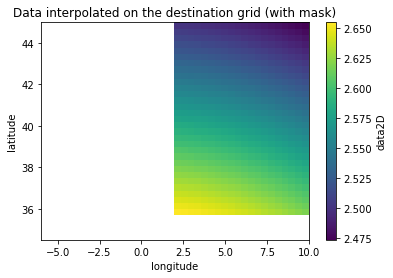

In [39]:
ds_in["data2D"].where(ds_in["mask"]==1).plot(x='lon',y='lat')
ax=plt.gca()
ax.set(title="Data interpolated on the destination grid (with mask)")

[Text(0.5, 1.0, 'Data on the original grid (with mask)')]

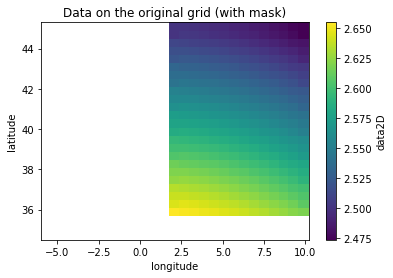

In [40]:
ds_out["data2D"].plot(x='lon',y='lat')
ax=plt.gca()
ax.set(title="Data on the original grid (with mask)")

# CONCLUSION AND NEW TESTS WITH LARGE SCALE PROBLEM

**The fixes to Issue1 and Issue2 does not solve the bottleneck with ```xarray``` package not being able to handle sparse array representation**. This is **especially an issue for large size problems** (real world). This makes the transition to the second type of issues : large regridding problem.